# Convolutional Neural Networks (2)

## Dataset

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import time

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision  # datasets and pretrained neural nets
import torch.utils.data
import torch.nn.functional as F
import torchvision.transforms as transforms


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.48216, 0.44653),
                                                     (0.24703, 0.24349, 0.26159))])

trainset = torchvision.datasets.CIFAR10(root='/Users/Lxy/Desktop/PyTorch/data', train=True, 
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='/Users/Lxy/Desktop/PyTorch/data', train=False, 
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32,
                                          shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, 
                                         shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainset.data.shape

(50000, 32, 32, 3)

## Building convolutional network

In [4]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # 32-3+2+1=32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 4 * 4, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 16 x 16
        x = self.pool(F.relu(self.conv2(x))) # 8 x 8
        x = self.pool(F.relu(self.conv3(x)))  #  4 x 4    feature map C x W x H --> linear.   
        x = x.view(-1, 128 * 4 * 4)
        return self.fc(x)  # (batch size, num_classes)

In [5]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

In [6]:
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

## Training

In [10]:
num_epochs = 10

since = time.time()
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    
    running_loss = 0.0
    running_corrects = 0
    
    for i, data in enumerate(trainloader, 0):
        # Get the inputs
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels) 
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / trainloader.dataset.data.shape[0]
    epoch_acc = running_corrects.double() / trainloader.dataset.data.shape[0]
    
    print('train Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))
    print('-' * 10)
    
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch 1/10
train Loss: 1.4168 Acc: 0.4957
----------
Epoch 2/10
train Loss: 1.0543 Acc: 0.6337
----------
Epoch 3/10
train Loss: 0.9006 Acc: 0.6888
----------
Epoch 4/10
train Loss: 0.8029 Acc: 0.7246
----------
Epoch 5/10
train Loss: 0.7256 Acc: 0.7517
----------
Epoch 6/10
train Loss: 0.6580 Acc: 0.7750
----------
Epoch 7/10
train Loss: 0.6022 Acc: 0.7941
----------
Epoch 8/10
train Loss: 0.5526 Acc: 0.8112
----------
Epoch 9/10
train Loss: 0.5059 Acc: 0.8273
----------
Epoch 10/10
train Loss: 0.4646 Acc: 0.8406
----------
Training complete in 12m 29s


## Evaluation

fc acc: 53%

In [11]:
correct, total = 0, 0
predictions = []
net.eval()  # mode:1.train(), 2.eval()
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1) 
    predictions.append(outputs)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('The testing set accuracy of the network is: %d %%' % ( 100 * correct / total))

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

The testing set accuracy of the network is: 74 %


## Add Validation

In [13]:
indices = np.arange(50000) 
indices

array([    0,     1,     2, ..., 49997, 49998, 49999])

In [26]:
np.random.shuffle(indices)
indices

array([ 8834,  2633,  7702, ..., 45782, 36898, 40124])

In [12]:
import numpy as np

indices = np.arange(50000) 
np.random.shuffle(indices)
indices

array([19925, 32449, 34245, ...,  8645, 14418, 18962])

In [14]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(
        root='/Users/Lxy/Desktop/PyTorch/data', 
        train=True, download=True,
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), 
                                                           (0.229, 0.224, 0.225))])), 
    batch_size=1, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices[:45000]))

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='/Users/Lxy/Desktop/PyTorch/data', 
                     train=True, download=True,
                     transform=transforms.Compose([transforms.ToTensor(),
                                                   transforms.Normalize((0.485, 0.456, 0.406), 
                                                                        (0.229, 0.224, 0.225))])), 
    batch_size=1, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices[45000:50000]))

Files already downloaded and verified
Files already downloaded and verified


## Save and Load models

In [22]:
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

`state_dict()`

In [8]:
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([32, 3, 3, 3])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
fc.weight 	 torch.Size([10, 2048])
fc.bias 	 torch.Size([10])


In [9]:
optimizer.state_dict()['param_groups']

[{'lr': 0.0003,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'params': [140713154307808,
   140713154307968,
   140713154307728,
   140713154307168,
   140713154308048,
   140713066267664,
   140713090038832,
   140713090039072]}]

### Saving & Loading Model for Inference
**Save**

In [15]:
PATH = './models/model_torch.pth'
torch.save(net.state_dict(), PATH)

**Load**

In [16]:
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

<All keys matched successfully>

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

The 1.6 release of PyTorch switched torch.save to use a new zipfile-based file format. torch.load still retains the ability to load files in the old format. If for any reason you want torch.save to use the old format, pass the kwarg `_use_new_zipfile_serialization=False`.

### Save/Load Entire Model
**Save**

In [21]:
torch.save(model, PATH)

**Load**

In [24]:
abd = torch.load(PATH)
abd.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

### Saving & Loading a General Checkpoint for Inference and/or Resuming Training
**Save**

In [31]:
PATH_CHECKPOINT = './models/checkpoint.tar'

torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH_CHECKPOINT)

**Load**

In [32]:
model = Net()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

checkpoint = torch.load(PATH_CHECKPOINT)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()

<All keys matched successfully>

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

### Saving Multiple Models in One File
**Save**

In [ ]:
torch.save({
            'modelA_state_dict': modelA.state_dict(),
            'modelB_state_dict': modelB.state_dict(),
            'optimizerA_state_dict': optimizerA.state_dict(),
            'optimizerB_state_dict': optimizerB.state_dict(),
            ...
            }, PATH)

**Load**

In [ ]:
modelA = ModelA(*args, **kwargs)
modelB = ModelB(*args, **kwargs)
optimizerA = OptimizerA(*args, **kwargs)
optimizerB = OptimizerB(*args, **kwargs)

checkpoint = torch.load(PATH)
modelA.load_state_dict(checkpoint['modelA_state_dict'])
modelB.load_state_dict(checkpoint['modelB_state_dict'])
optimizerA.load_state_dict(checkpoint['optimizerA_state_dict'])
optimizerB.load_state_dict(checkpoint['optimizerB_state_dict'])

modelA.eval()
modelB.eval()
# - or -
modelA.train()
modelB.train()

## Arch
AlexNet

In [56]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000): 
        super(AlexNet, self).__init__() 
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=3, stride=2), 
            nn.Conv2d(96, 256, kernel_size=5, padding=2), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True), 
            nn.Conv2d(384, 256, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=3, stride=2),)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6)) # 最终输的size
        self.classifier = nn.Sequential(
            nn.Dropout(), 
            nn.Linear(256 * 6 * 6, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(), 
            nn.Linear(4096, 4096), 
            nn.ReLU(inplace=True), 
            nn.Linear(4096, num_classes))
            
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6) 
        x = self.classifier(x)
        return x

In [74]:
alex = AlexNet()
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

VGG

In [58]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

In [59]:
test()

torch.Size([2, 10])


In [61]:
vgg_16 = VGG('VGG16')
vgg_16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Transfer learning


### Freeze

In [63]:
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [64]:
alex.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [75]:
# Freeze all the layers bar the final one
for param, name in zip(alex.parameters(), alex.state_dict().keys()): 
    s = param.requires_grad
    param.requires_grad = False
    print(name,":", s, param.requires_grad)

features.0.weight : True False
features.0.bias : True False
features.3.weight : True False
features.3.bias : True False
features.6.weight : True False
features.6.bias : True False
features.8.weight : True False
features.8.bias : True False
features.10.weight : True False
features.10.bias : True False
classifier.1.weight : True False
classifier.1.bias : True False
classifier.4.weight : True False
classifier.4.bias : True False
classifier.6.weight : True False
classifier.6.bias : True False


In [78]:
alex.classifier[6] = nn.Linear(4096, 10)
for param, name in zip(alex.parameters(), alex.state_dict().keys()): 
    print(name,":", param.requires_grad)

features.0.weight : False
features.0.bias : False
features.3.weight : False
features.3.bias : False
features.6.weight : False
features.6.bias : False
features.8.weight : False
features.8.bias : False
features.10.weight : False
features.10.bias : False
classifier.1.weight : False
classifier.1.bias : False
classifier.4.weight : False
classifier.4.bias : False
classifier.6.weight : True
classifier.6.bias : True


In [79]:
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Framework

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

**Load Data**

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/Users/Lxy/Desktop/PyTorch/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [84]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: /Users/Lxy/Desktop/PyTorch/data/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: /Users/Lxy/Desktop/PyTorch/data/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [85]:
dataset_sizes
class_names

{'train': 244, 'val': 153}

['ants', 'bees']

**Visualize**

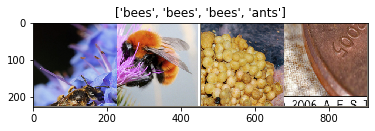

In [86]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Training function**
* Scheduling the learning rate
* Saving the best model

In [87]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Finetuning the convnet**

Load a pretrained model and reset final fully connected layer.

In [108]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [109]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Train and evaluate**

In [110]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6805 Acc: 0.6762
val Loss: 0.2830 Acc: 0.8954

Epoch 1/9
----------
train Loss: 0.4662 Acc: 0.8033
val Loss: 0.5419 Acc: 0.8105

Epoch 2/9
----------
train Loss: 0.5992 Acc: 0.7705
val Loss: 0.3944 Acc: 0.8758

Epoch 3/9
----------
train Loss: 0.6027 Acc: 0.7541
val Loss: 0.3588 Acc: 0.8889

Epoch 4/9
----------
train Loss: 0.4633 Acc: 0.8115
val Loss: 0.3325 Acc: 0.9020

Epoch 5/9
----------
train Loss: 0.4293 Acc: 0.8033
val Loss: 0.1910 Acc: 0.9216

Epoch 6/9
----------
train Loss: 0.2860 Acc: 0.8811
val Loss: 0.1575 Acc: 0.9608

Epoch 7/9
----------
train Loss: 0.3577 Acc: 0.8238
val Loss: 0.1593 Acc: 0.9281

Epoch 8/9
----------
train Loss: 0.2642 Acc: 0.8893
val Loss: 0.1545 Acc: 0.9412

Epoch 9/9
----------
train Loss: 0.2596 Acc: 0.9016
val Loss: 0.1453 Acc: 0.9477

Training complete in 11m 34s
Best val Acc: 0.960784


**ConvNet as fixed feature extractor**

Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly sconstructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_con = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_con, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_con,
                                      exp_lr_scheduler, num_epochs=25)